In [1]:
import numpy as np
import pandas as pd
from scipy.io import netcdf
import scipy.signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand
from wavesim1d import *



%load_ext autoreload
%autoreload 2

In [2]:
#Load a sample avg spectra

#fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
test_spectra = np.mean(spectra[100:110, :], 0)
f2 = np.linspace(f[0], f[-1], num=256)
spec2 = np.interp(f2, f, test_spectra)
f = f2
test_spectra = spec2

2.770427451362952
2.428978146509699
1.6334429362938998


Text(0.5, 1.0, 'Hann Window')

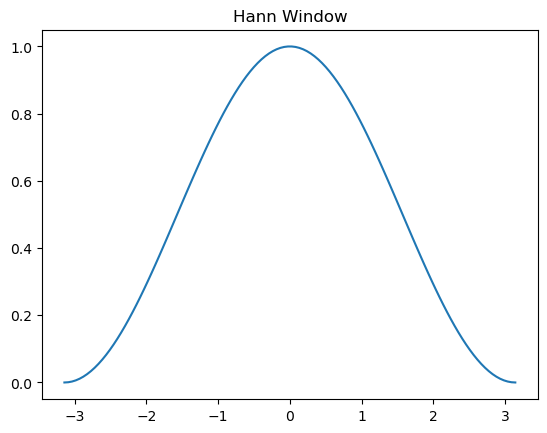

In [25]:
#

#Now make a 2-d  velocity grid field from a spectrum
#Assume random phase, and random direction

x_range = np.arange(0, 10, 1)
z_range = np.arange(0, 1, 1)
t_range_surf = np.arange(0, 1200, 1)
#xx, zz = np.meshgrid(x_range, z_range)
tt, zzt = np.meshgrid(t_range_surf, z_range)

#tt, xx, zz = np.meshgrid(x_range, z_range, t_range)
#y_range = [0, 100]

#Normally would loop through at each time step and generate a x-z wave field
#Lets start with t=0
n_iter = 500

fs = 1
u_store_surf = np.zeros((n_iter, len(t_range_surf)));

#Number of iterations to run
zeta_store = np.zeros((n_iter, len(t_range_surf)))
df = f[2]-f[1]
t = 0
x = 0
for jj in range(0, n_iter-1):
    for i in range(0, len(f)-1):
        freq = f[i]
        if i == 0:
            df = f[1]-f[0]
        elif i == len(f)-1:
            df = f[i]-f[i-1]
        else:
            i
            df = (f[i+1]-f[i-1])/2
            
        omega = 2*np.pi*freq;
        k = np.sqrt(omega/9.8)
        a = np.sqrt(test_spectra[i]*df*2) # Is this the right conversion to wave amplitude? 

        #Randomize phase
        phi = rand.random()*2*np.pi;
        
        #Randomize direction?
        #TO DO: Need to have peak in narrow directional band
        #Should we be able to input directional spectra
        
        u = a*omega*np.cos(k*x-omega*tt + phi)*np.exp(-k*zzt)
        zeta = a*np.cos(k*x-omega*t_range_surf + phi)
        #print(u)
        u_store_surf[jj, :] = u_store_surf[jj, :] + u
        zeta_store[jj, :] = zeta_store[jj, :] + zeta
#how do we choose the amplitude for each frequency?


##Add white noise to the surface measurements

mean = 0
std = 0.01 
num_samples = len(u_store_surf[:, 0])*len(u_store_surf[0, :])
rand_samples = 0.008*np.random.normal(loc = 0, scale = 1, size = num_samples)
rand_samples = rand_samples.reshape((len(u_store_surf[:, 0]), len(u_store_surf[0, :])))
u_noise_surf = u_store_surf + rand_samples

#Now we take the spectra

nblock = 120
overlap = int(nblock/2)
fs = 1
Cmax = 1000
w = nblock


#Em-APEX Sampling Grid
t_range = np.arange(0, 1000)
t_range, em_x, em_z = apex_sampling_grid(t_range)

#build the u-time-series
[u_store, u_noise] = build_u_timeseries(t_range, em_z, em_x, test_spectra, f)

#Reshape the u time series
[u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
[u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


#Make the actual spectra by calling the function above
UUwindow, fwindow= make_vel_spectrum(u_new, fs)
UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise, fs)


#Compute the raw Energy Density Spectra
UU = np.nanmean(np.nanmean(UUwindow, axis=0), axis=0)/(int(w/2)*fs)
#UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
#Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))


[u_surf, z_new] = reshape_u(u_noise_surf, t_range_surf, nblock, overlap, fs)
UUwindow_surf, fwindow_surf= make_vel_spectrum(u_surf, fs)
UU_surf = np.nanmean(UUwindow_surf, axis=0)/(int(w/2)*fs)
Exx_surf = np.nanmean(UU_surf[:, 1:], axis=0)/ (np.square((2*np.pi*fwindow_surf[1:])))


win = scipy.signal.windows.hann(nblock, True)
f_scipy, Pxxf = scipy.signal.welch(u_surf, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)
plt.plot(np.linspace(0, 120, 120)*2*np.pi/120-np.pi, win)
plt.title("Hann Window")

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_47488/2131797916.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(f_scipy, np.nanmean(np.nanmean(Pxxf, axis=0), axis=0)/(np.square((2*np.pi*f_scipy))))


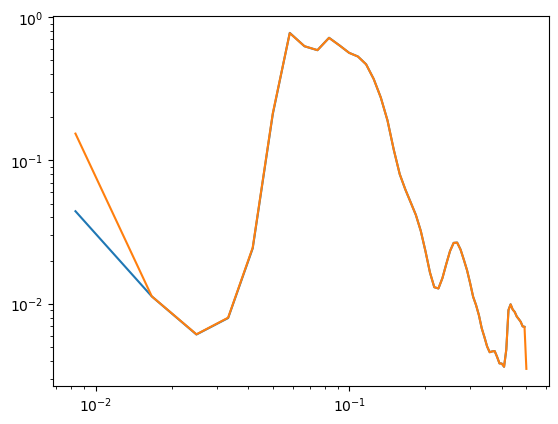

In [26]:
plt.loglog(fwindow_surf[1:], Exx_surf)
plt.loglog(f_scipy, np.nanmean(np.nanmean(Pxxf, axis=0), axis=0)/(np.square((2*np.pi*f_scipy))))